# 1 레버리지와 아웃라이어
# 2 다중공선성

# 평균의 함정에 빠지지 않으려면
## 데이터가 선형일 때만 가능함
* https://bkshin.tistory.com/entry/DATA-26-Same-Stats-Different-Graphs
* 히트맵 상관계수를 숫자로만 보면 앤스컴(Anscombe's Quarter)에 걸린다. scatter를 그려보는 게 가장 확실(절반은 그래프, 절반은 숫자)
* 심슨의 역설 - 카테고리별로 나눠보는 것. 뭉뚱그려 평균을 내면 평균의 함정에 빠진다
* 평균을 구하되 상하위 10%를 버리고 평균을 구하기
* 중위값을 가져오기

# Chart Junk
* https://bkshin.tistory.com/entry/DATA-27-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%8B%9C%EA%B0%81%ED%99%94-Data-Visualization
* 차트 시각화하는데 필요없는 것들
* Lie Factor - 실제 데이터보다 과장되게 그리는 정도

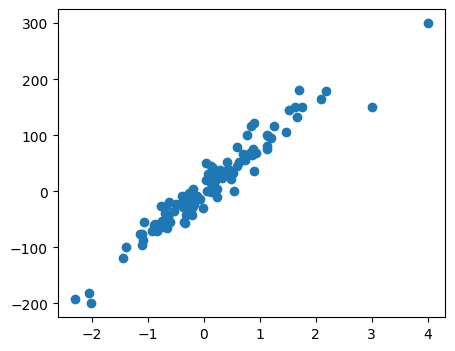

In [12]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np

X, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True, random_state=1)

X = np.vstack([X, np.array([[3], [4]])])
y = np.hstack([y, np.array([150, 300])])

plt.figure(figsize=(5,4))
plt.scatter(X, y)
plt.show()

In [13]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X)) # add_constant 편향 추가
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Mon, 26 Jun 2023   Prob (F-statistic):           1.61e-61
Time:                        13:42:28   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2565      2.065      1.577      0.1

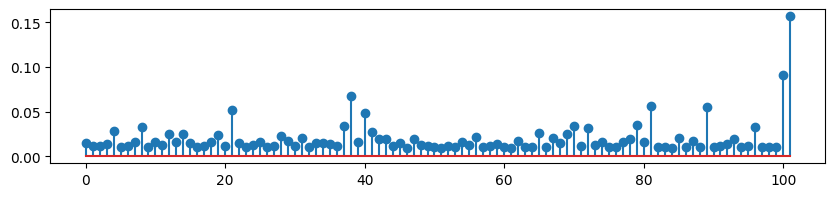

In [14]:
hat = result.get_influence().hat_matrix_diag

plt.figure(figsize=(10,2))
plt.stem(hat)
plt.show()

In [15]:
hat.sum() # 레버리지의 합은 항상 2 (수학적인)
hat.mean() # 평균은 0.02, 2~3배 정도 큰 데이터는 레버리지가 크다고 볼 수 있다.

0.019607843137254905

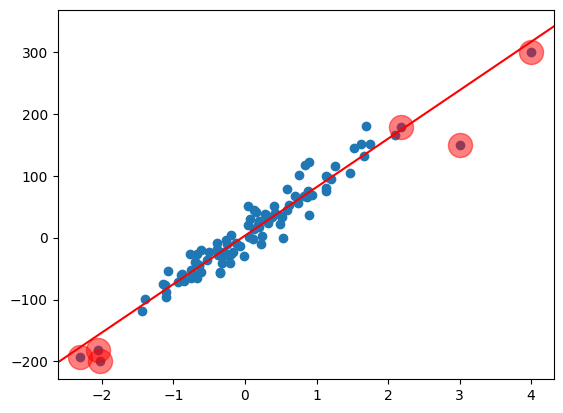

In [16]:
ax = plt.subplot()
ax.scatter(X, y)
sm.graphics.abline_plot(model_results=result, ax=ax, color='red') # 모델이 학습한 최적의 선형 가중치
lev = hat > 0.05
plt.scatter(X[lev], y[lev], s=300, c='r', alpha=0.5) # 레버리지가 큰 데이터(>0.05)
plt.show()

In [17]:
np.argmax(hat)

101

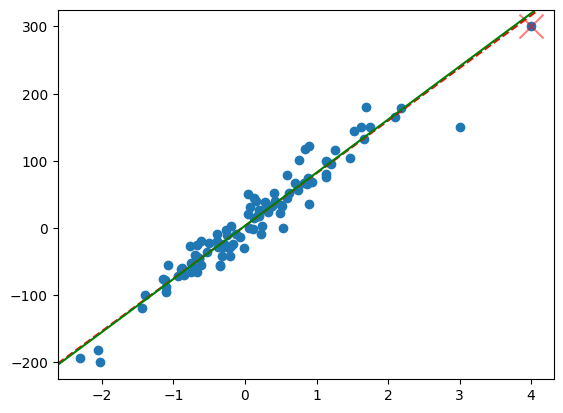

In [24]:
model2 = sm.OLS(y[:-1], sm.add_constant(X[:-1])) # add_constant 편향 추가
result2 = model2.fit()

ax = plt.subplot()

ax.scatter(X, y)

sm.graphics.abline_plot(model_results=result, ax=ax, c='r', linestyle='--') # 모델이 학습한 최적의 선형 가중치
sm.graphics.abline_plot(model_results=result2, ax=ax, c='g') # 모델이 학습한 최적의 선형 가중치

plt.scatter(X[-1], y[-1], marker='x', s=300, c='r', alpha=0.5)

plt.show()

* 레버리지 - 영향력의 크기
* 레버리지는 101번이 크지만, 모델에 미치는 영향은 100번이 크다
* 레버리지와 엇나간 정도를 더해서 outlier를 정한다
* 잔차 - 예측값과 실제값의 차이

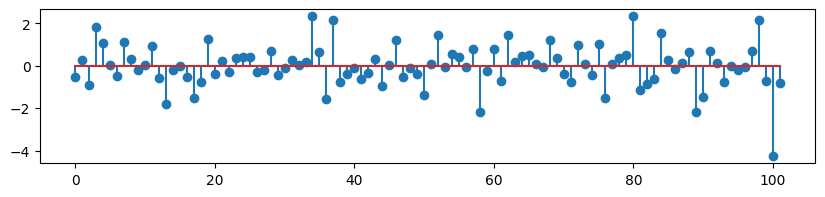

In [31]:
# residual 잔차
# result.resid
plt.figure(figsize=(10,2))
# plt.stem(result.resid) # 잔차
plt.stem(result.resid_pearson) # 표준화된 잔차
plt.show()

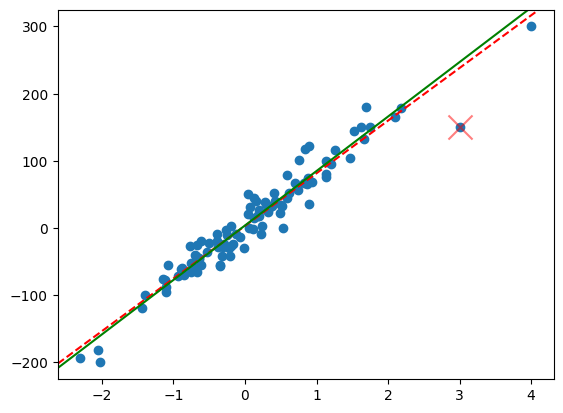

In [26]:
idx = np.array(list(range(100)) + [101]) # 100번 빼고
model3 = sm.OLS(y[idx], sm.add_constant(X[idx])) # add_constant 편향 추가
result3 = model3.fit()

ax = plt.subplot()

ax.scatter(X, y)

sm.graphics.abline_plot(model_results=result, ax=ax, c='r', linestyle='--') # 모델이 학습한 최적의 선형 가중치
sm.graphics.abline_plot(model_results=result3, ax=ax, c='g') # 모델이 학습한 최적의 선형 가중치

plt.scatter(X[100], y[100], marker='x', s=300, c='r', alpha=0.5)

plt.show()

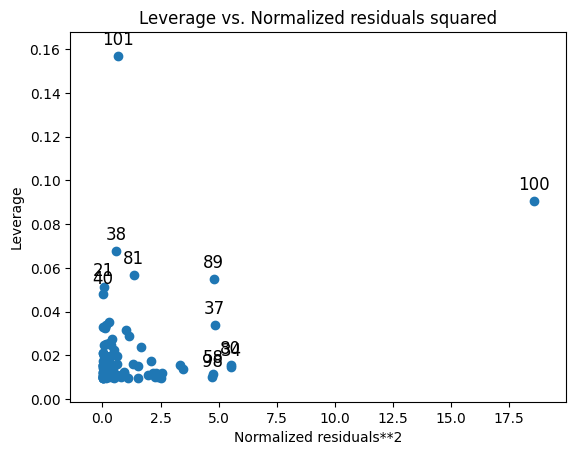

In [33]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

In [42]:
influ = result.get_influence()
cooks, pvalue = influ.cooks_distance # Di값 / 두 번째 array는 p값, 신뢰도

fox = 4 / (len(y) - influ.k_vars - 1) # fox 이론
fox

0.04040404040404041

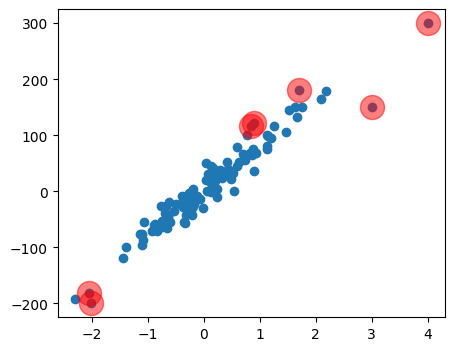

In [43]:
outlier = cooks > fox

plt.figure(figsize=(5,4))
plt.scatter(X, y)
plt.scatter(X[outlier], y[outlier], s=300, c='r', alpha=0.5)
plt.show()


# 다중공선성

In [49]:
from statsmodels.datasets.longley import load_pandas
import pandas as pd

longley = load_pandas()
y = longley.endog
X = longley.exog
df = pd.concat([y, X], axis=1)
df

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,60323.0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,61122.0,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,60171.0,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,61187.0,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,63221.0,96.2,328975.0,2099.0,3099.0,112075.0,1951.0
5,63639.0,98.1,346999.0,1932.0,3594.0,113270.0,1952.0
6,64989.0,99.0,365385.0,1870.0,3547.0,115094.0,1953.0
7,63761.0,100.0,363112.0,3578.0,3350.0,116219.0,1954.0
8,66019.0,101.2,397469.0,2904.0,3048.0,117388.0,1955.0
9,67857.0,104.6,419180.0,2822.0,2857.0,118734.0,1956.0


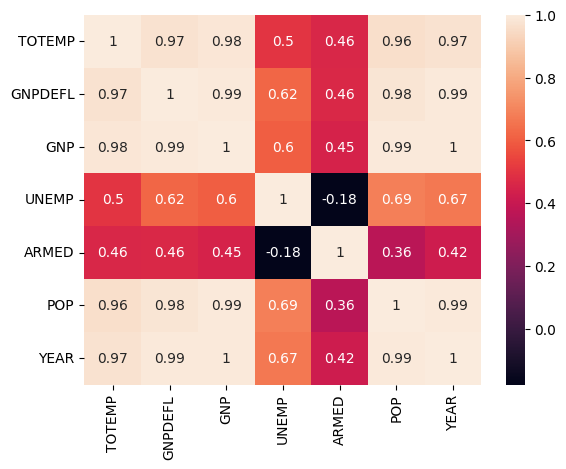

<Figure size 640x480 with 0 Axes>

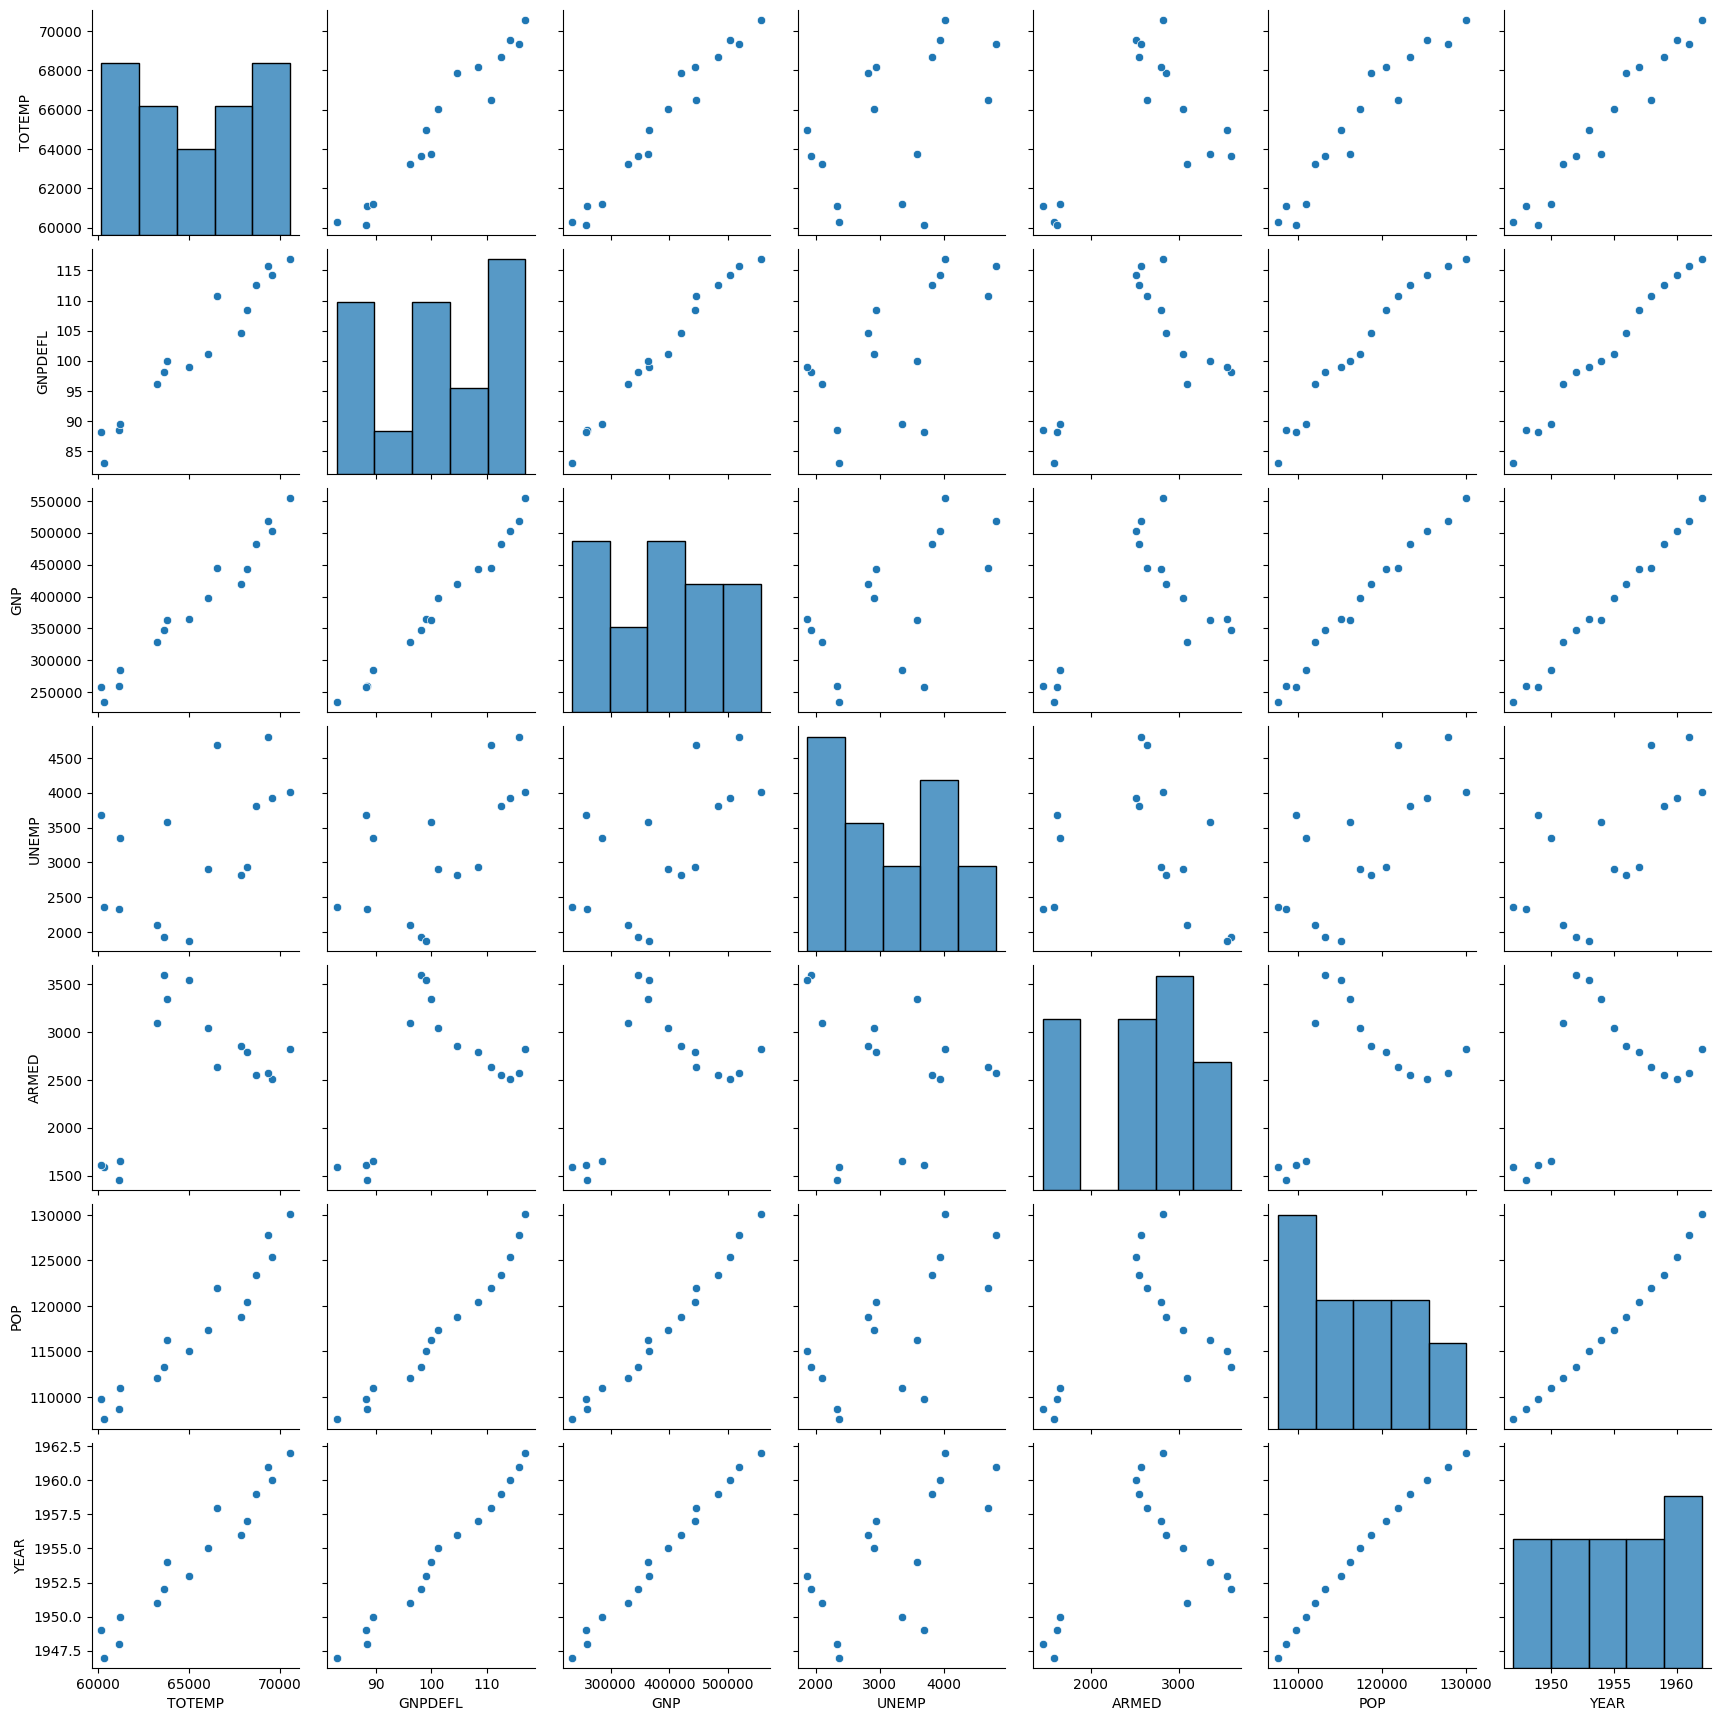

In [53]:
import seaborn as sns

plt.figure()
sns.heatmap(df.corr(), annot=True)
plt.show()

plt.figure()
sns.pairplot(df)
plt.show()

In [55]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.4, random_state=1)
model = sm.OLS(df_train['TOTEMP'], df_train.iloc[:, 1:])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                 TOTEMP   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.587e+04
Date:                Mon, 26 Jun 2023   Prob (F-statistic):                    7.73e-07
Time:                        15:08:37   Log-Likelihood:                         -66.014
No. Observations:                   9   AIC:                                      144.0
Df Residuals:                       3   BIC:                                      145.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

c:\Users\PC\Bcode\myvenv\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [57]:
from sklearn.metrics import r2_score

p_test = result.predict(df_test.iloc[:, 1:])
r2_score(df_test['TOTEMP'], p_test)

0.9663885278269153

* X의 변수 하나를 나머지의 변수로 맞힐 수 있으면 다중공선성이 높으니, 제거해도 됨?

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# vif가 10 이상이면 다중공선성이 있다고 판단. 
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif

[12425.514335354637,
 10290.435436791722,
 136.2243535629104,
 39.9833855829122,
 101193.16199321792,
 84709.9504430369]

In [62]:
for column, v in zip(X.columns, vif):
    print(column, v)

GNPDEFL 12425.514335354637
GNP 10290.435436791722
UNEMP 136.2243535629104
ARMED 39.9833855829122
POP 101193.16199321792
YEAR 84709.9504430369


In [63]:
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['feature'] = X.columns
vif

,vif,feature
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


In [65]:
vif.sort_values('vif')

,vif,feature
3,39.983386,ARMED
2,136.224354,UNEMP
1,10290.435437,GNP
0,12425.514335,GNPDEFL
5,84709.950443,YEAR
4,101193.161993,POP


In [74]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_train_sc = scaler.fit_transform(df_train.loc[:, ['ARMED', 'UNEMP', 'GNP']])

model2 = sm.OLS.from_formula('TOTEMP ~ scale(ARMED) + scale(UNEMP) + scale(GNP)', df_train)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     76.71
Date:                Mon, 26 Jun 2023   Prob (F-statistic):           0.000133
Time:                        16:02:51   Log-Likelihood:                -68.631
No. Observations:                   9   AIC:                             145.3
Df Residuals:                       5   BIC:                             146.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       6.6e+04    221.861    297.489   

c:\Users\PC\Bcode\myvenv\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [76]:
# df_test_sc = scaler.transform(df_test.loc[:, ['ARMED', 'UNEMP', 'GNP']])

P_test = result2.predict(df_test.loc[:, ['ARMED', 'UNEMP', 'GNP']])
r2_score(df_test['TOTEMP'], P_test)

0.9889103109315419

In [78]:
# vif가 10 이상이면 다중공선성이 있다고 판단. 이 정도면 괜찮다.

vif = pd.DataFrame()
X_cleaned = df_test.loc[:, ['ARMED', 'UNEMP', 'GNP']]
vif['vif'] = [variance_inflation_factor(X_cleaned, i) for i in range(X_cleaned.shape[1])]
vif['feature'] = X_cleaned.columns
vif

,vif,feature
0,16.520975,ARMED
1,12.713385,UNEMP
2,35.873914,GNP


In [83]:
bonston = pd.read_csv('./src/boston.csv')
X = bonston.drop(columns=['ID', 'MEDV', 'CMEDV', 'TOWN'], axis=1)
X

,TOWNNO,TRACT,LON,LAT,x,y,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.0,2011.0,-70.9550,42.2550,338.73,4679.73,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,1.0,2021.0,-70.9500,42.2875,339.23,4683.33,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,1.0,2022.0,-70.9360,42.2830,340.37,4682.80,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,2.0,2031.0,-70.9280,42.2930,341.05,4683.89,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,2.0,2032.0,-70.9220,42.2980,341.56,4684.44,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,91.0,1801.0,-70.9860,42.2312,336.11,4677.14,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,91.0,1802.0,-70.9910,42.2275,335.69,4676.74,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,91.0,1803.0,-70.9948,42.2260,335.37,4676.58,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,91.0,1804.0,-70.9875,42.2240,335.97,4676.35,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


# 다중공선성 제거를 위한 코드

In [84]:
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['feature'] = X.columns
vif.sort_values('vif')

,vif,feature
9,1.190814e+00,CHAS
6,2.148796e+00,CRIM
7,2.967360e+00,ZN
18,1.231521e+01,LSTAT
8,1.498360e+01,INDUS
17,2.222587e+01,B
0,2.322620e+01,TOWNNO
12,2.388794e+01,AGE
14,2.762313e+01,RAD
13,3.064329e+01,DIS
